In [1]:
from numpy import savetxt

import lumicks.pylake as lk
from pathlib import Path
import csv
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO 
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import operator
from scipy.interpolate import CubicSpline

In [14]:
directory = '//cmcb-files/jahnel_transitions/miRNA/230508_RNA-233_YBX1-GFP/'

file_list = list(Path(directory).glob('*.h5'))



In [27]:
file1 = lk.File(file_list[2])
file2 = lk.File(file_list[8])
file3 = lk.File(file_list[10])
file4 = lk.File(file_list[12])
file5 = lk.File(file_list[14])
file6 = lk.File(file_list[16])
file7 = lk.File(file_list[19])

file9 = lk.File(file_list[21])

file5 = lk.File('20230508-145011 with Piezo FD Curve 5.h5')
file10 = lk.File('20230508-154747 with Piezo FD Curve 10.h5')
file11 = lk.File('20230508-155107 with Piezo FD Curve 11.h5')
s = len( file11['Force HF']['Force 2x'])
# fd_11 = lk.File(file_list[24])

# print(fd_11)


In [23]:
start = 0
end = s//4


In [87]:
force_2x_11 = file11['Force HF']['Corrected Force 2x']
distance_1_11 = file11['Distance']['Piezo Distance']
#force_2x_ds, distance_1_ds = force_2x.downsampled_like(distance_1)



f11 = np.array(force_2x_11.data[start:end].data)
d11 = np.array(distance_1_11.data[start:end].data)

# with open('df11_less_2.csv',mode='w', newline='') as f:
#     writer = csv.writer(f)
#     for i in range(len(f11)):
#         writer.writerow([f11[i], d11[i]])


In [88]:
# create list with data
mir223 = []
ind1 = [2, 8,10, 12, 14,16, 19, 21, 23, 25]
for i in ind1:
    mir223.append(lk.File(file_list[i]))
    
ybx1 = []

ind2 = [14,16, 19]
for i in ind2:
    ybx1.append(lk.File(file_list[i]))



In [182]:
def cutout_first_stretch(set_com):
    """This functions cuts out the first stretch (from start till the maximum of the position) of positions and values of a given set.
    Returns an array with the cut positions and values.
    
    INPUT:
    set_com - Array; [position data, value data]
    
    OUTPUT:
    [positions_cut, values_cut] - Array; [cut positions, cut values]
    """
    positions_com, values_com = set_com
    
    positions_cut = positions_com[:np.argmax(positions_com)+1]
    values_cut = values_com[:np.argmax(positions_com)+1]
    
    return [positions_cut, values_cut]
def cutout_first_relax(set_com):
    """This functions cuts out the first relax (from the first maximum of the position to the first minimum afterwards) of positions and values of a given set.
    Returns an array with the cut positions and values.
    
    INPUT:
    set_com - Array; [position data, value data]
    
    OUTPUT:
    [positions_cut, values_cut] - Array; [cut positions, cut values]
    """
    positions_com, values_com = set_com
    
    positions_argmax = np.argmax(positions_com)+1
    
    positions_argmin = np.argmin(positions_com[positions_argmax:])

    positions_cut = positions_com[positions_argmax:positions_argmax+positions_argmin]
    values_cut = values_com[positions_argmax:positions_argmax+positions_argmin]
    
    return [positions_cut, values_cut]

In [99]:
start = 0
end = s//4-100000



Text(0.5, 1.0, 'Force vs Distance')

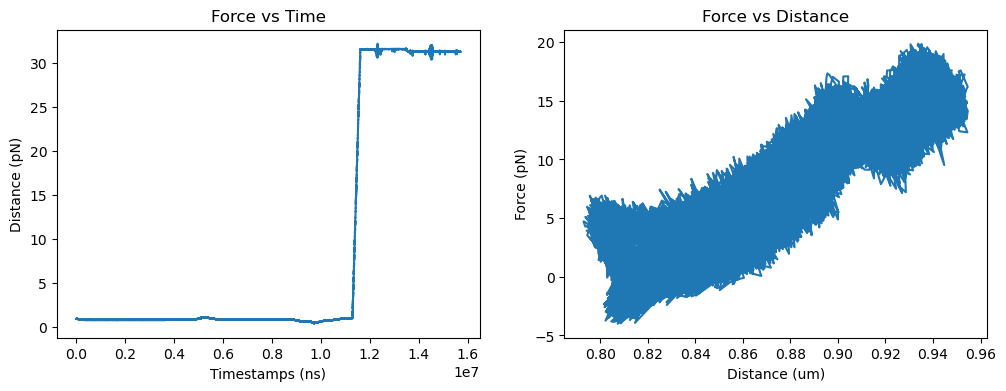

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ax[0].plot(distance_1_11.data)
ax[0].set_ylabel("Distance (pN)")
ax[0].set_xlabel("Timestamps (ns)")
ax[0].set_title("Force vs Time")

ax[1].plot(d11, f11)
ax[1].set_ylabel("Force (pN)")
ax[1].set_xlabel("Distance (um)")
ax[1].set_title("Force vs Distance")


In [12]:
len(distance_1_11.timestamps)
# distance_1_11.timestamps[0:100]

15712813

In [89]:
def downsample(data, N):
    length = int(len(data) / N)
    values = np.zeros(length)
    
    for i in range(length):
        values[i] = np.mean(data[i*N : (i+1)*N-1])
        
#         err = np.sqrt(np.var(data[i*N : (i+1)*N-1]))/values[i]
#         print(err)
#         if err >= 0.05:
#             print(i, 'error higher then 5 %')
    
    return values


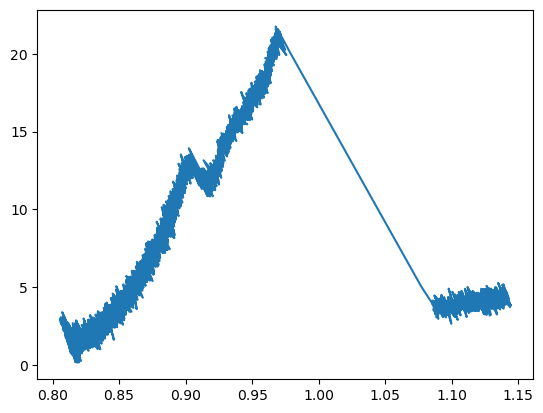

In [90]:
N = 100

d_down = downsample(distance_1_11.data, N)
f_down = downsample(force_2x_11.data, N)

bs_ = 1000
es_ = len(f_down)

plt.plot(d_down[bs_:es_//3], f_down[bs_:es_//3])

In [91]:
#downsampled data using pylake function downsampled_by()

downsampled_rate = 100 # Hz
sample_rate = force_2x_11.sample_rate

time = (force_2x_11.timestamps - force_2x_11.timestamps[0]) /1e9
force_2x_11_downsamp = force_2x_11.downsampled_by(int(sample_rate/downsampled_rate))
time_downsampled = (force_2x_11_downsamp.timestamps- force_2x_11_downsamp.timestamps[0]) /1e9

time_d = (distance_1_11.timestamps- distance_1_11.timestamps[0]) /1e9
distance_1_11_downsamp = distance_1_11.downsampled_by(int(sample_rate/downsampled_rate))
time_downsampled_d = (distance_1_11_downsamp.timestamps- distance_1_11_downsamp.timestamps[0]) /1e9

20118

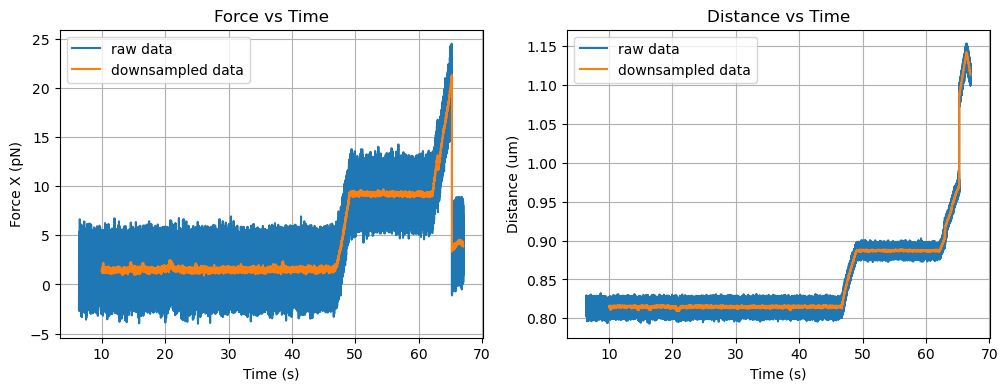

In [92]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
e = len(time)
b = 500000
bs = 1000
es = len(time_downsampled)

ax[0].plot(time[b:e//3], force_2x_11.data[b:e//3], label = 'raw data')
ax[0].plot(time_downsampled[bs:es//3], force_2x_11_downsamp.data[bs:es//3], label = 'downsampled data')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Force X (pN)')
ax[0].set_title("Force vs Time")


ax[1].plot(time_d[b:e//3], distance_1_11.data[b:e//3], label = 'raw data')
ax[1].plot(time_downsampled_d[bs:es//3], distance_1_11_downsamp.data[bs:es//3], label = 'downsampled data')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Distance (um)')
ax[1].set_title("Distance vs Time")


for i in range(2):
    ax[i].legend()
    ax[i].grid()


len(time_downsampled[:end//4])


# miRNA223 with YBX1


In [430]:
force_5 = file5['Force HF']['Corrected Force 2x']
distance_5 = file5['Distance']['Piezo Distance']

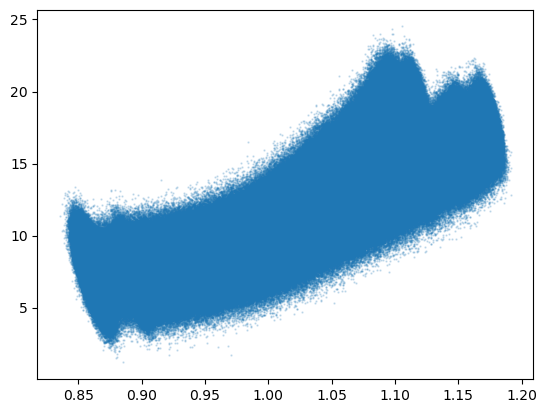

In [431]:
plt.scatter(distance_5.data, force_5.data, s=0.5, alpha=0.2, label = 'raw data')

In [432]:
downsampled_rate = 100 # Hz
sample_rate = force_5.sample_rate

time = (force_5.timestamps - force_5.timestamps[0]) /1e9
force_5_downsamp = force_5.downsampled_by(int(sample_rate/downsampled_rate))
time_downsampled = (force_5_downsamp.timestamps- force_5_downsamp.timestamps[0]) /1e9

time_d = (distance_5.timestamps- distance_5.timestamps[0]) /1e9
distance_5_downsamp = distance_5.downsampled_by(int(sample_rate/downsampled_rate))
time_downsampled_d = (distance_5_downsamp.timestamps- distance_5_downsamp.timestamps[0]) /1e9

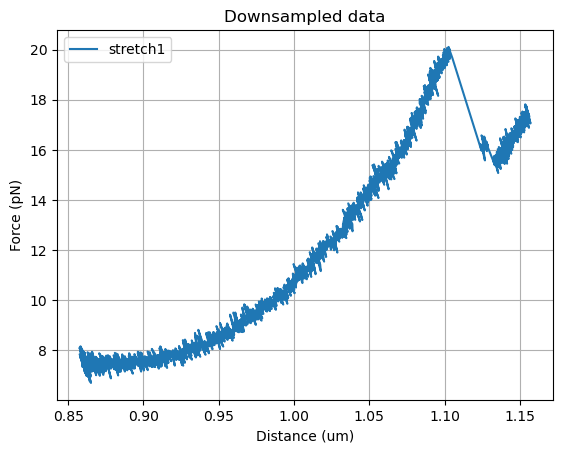

In [439]:
# fig, ax = plt.subplots(ncols=1, figsize=(12,4))
# plt.plot(d_down[bs_:es_//3], f_down[bs_:es_//3])
s = 0
e = len(distance_5_downsamp)
plt.plot(distance_5_downsamp.data[s:e//2-50], force_5_downsamp.data[s:e//2-50], label = 'stretch1')
plt.ylabel('Force (pN)')
plt.xlabel('Distance (um)')
plt.title('Downsampled data')

p = e//2-50
plt.legend()
plt.grid()

W_ds 8.310688674162321 1e-18 J


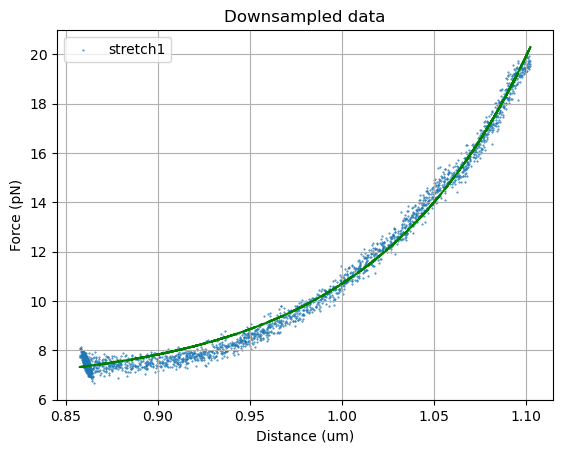

In [440]:
# fig, ax = plt.subplots(ncols=1, figsize=(12,4))
# plt.plot(d_down[bs_:es_//3], f_down[bs_:es_//3])
def func(x, m, t, b):
    return m * np.exp(-t * x) + b
s = 0
popt, pcov = curve_fit(func, distance_5_downsamp.data[s:e//2-520],  force_5_downsamp.data[s:e//2-520])
plt.plot(distance_5_downsamp.data[s:e//2-520], func(distance_5_downsamp.data[s:e//2-520], *popt), 'g')


e = len(distance_5_downsamp)
plt.scatter(distance_5_downsamp.data[s:e//2-520], force_5_downsamp.data[s:e//2-520], s = 0.2, alpha = 1, label = 'stretch1')

plt.ylabel('Force (pN)')
plt.xlabel('Distance (um)')
plt.title('Downsampled data')

q = e//2-520
plt.legend()
plt.grid()

distance1 = np.arange(0, 1.1, 0.001)
w_ds = np.trapz(func(distance1, *popt), dx = 0.001)
print('W_ds', w_ds, 1e-18,  'J')

W_ss 7.323088960814207 1e-18 J


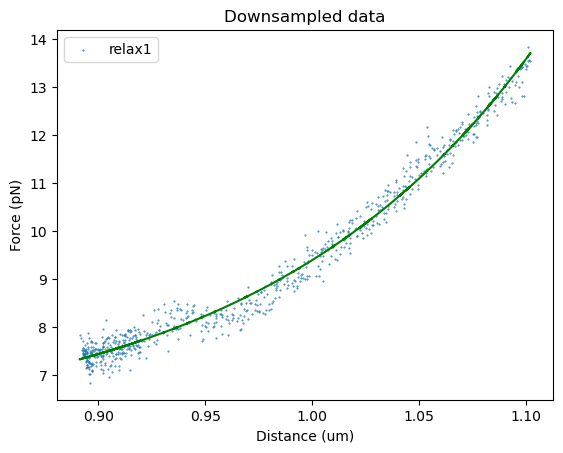

In [441]:
def func(x, m, t, b):
    return m * np.exp(-t * x) + b

popt, pcov = curve_fit(func, distance_5_downsamp.data[p+100:e-3200],  force_5_downsamp.data[p+100:e-3200])
plt.plot(distance_5_downsamp.data[p+100:e-3200], func(distance_5_downsamp.data[p+100:e-3200], *popt), 'g')

s = 0
e = len(distance_5_downsamp)
plt.scatter(distance_5_downsamp.data[p+100:e-3200], force_5_downsamp.data[p+100:e-3200],s = 0.2, alpha = 1, label = 'relax1')
plt.ylabel('Force (pN)')
plt.xlabel('Distance (um)')
plt.title('Downsampled data')

p1 = e-3200
plt.legend()
plt.grid()

plt.legend()
plt.grid()
distance1 = np.arange(0, 1.1, 0.001)
w_ss = np.trapz(func(distance1, *popt), dx = 0.001)
print('W_ss', w_ss, 1e-18,  'J')

W_ds 8.310688674162321 1e-18 J
W_ss 7.323088960814207 1e-18 J
W_step 1.0174483960911247 1e-18 J
W_structure 2.005048109439239 1e-18 J
Work_structure 288.69623580062705 kcal/mol


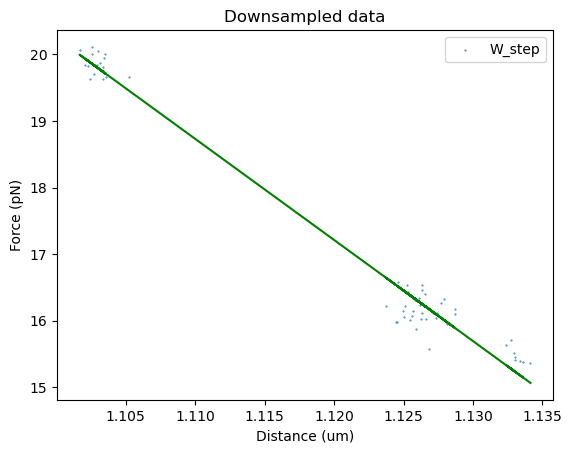

In [442]:
def func(x, a, b):
    return a* x + b

popt, pcov = curve_fit(func, distance_5_downsamp.data[e//2-520:p-410],  force_5_downsamp.data[e//2-520:p-410])
plt.plot(distance_5_downsamp.data[e//2-520:p-410], func(distance_5_downsamp.data[e//2-520:p-410], *popt), 'g')

s = 0
e = len(distance_5_downsamp)
plt.scatter(distance_5_downsamp.data[e//2-520:p-410], force_5_downsamp.data[e//2-520:p-410],s = 0.2, alpha = 1, label = 'W_step')
plt.ylabel('Force (pN)')
plt.xlabel('Distance (um)')
plt.title('Downsampled data')

p1 = e-3200
plt.legend()
plt.grid()

plt.legend()
plt.grid()
w_step = np.trapz(func(distance_5_downsamp.data[e//2-520:p-410], *popt), dx = 0.001)

print('W_ds', w_ds, 1e-18,  'J')
print('W_ss', w_ss, 1e-18,  'J')
print('W_step', w_step, 1e-18,  'J')

print('W_structure', w_ds-w_ss +w_step, 1e-18,  'J')
print('Work_structure', (w_ds-w_ss + w_step)* 6.02/4181*10**5, 'kcal/mol')

In [462]:
 2.005/ 4181

0.00047955034680698393

W_ss 7.323088960814207 1e-18 J


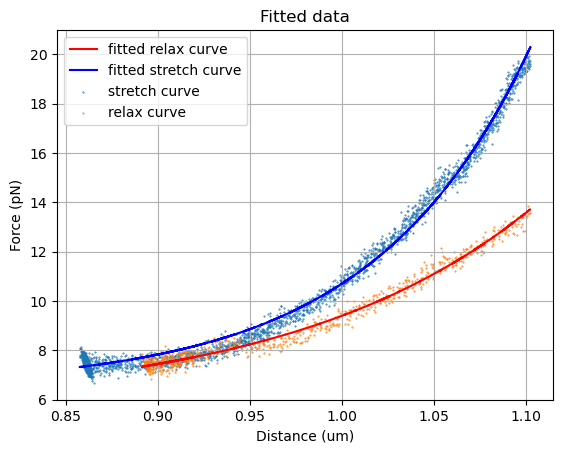

In [416]:
def func(x, m, t, b):
    return m * np.exp(-t * x) + b

popt, pcov = curve_fit(func, distance_5_downsamp.data[p+100:e-3200],  force_5_downsamp.data[p+100:e-3200])
plt.plot(distance_5_downsamp.data[p+100:e-3200], func(distance_5_downsamp.data[p+100:e-3200], *popt), 'r', label = 'fitted relax curve')

plt.plot(distance_5_downsamp.data[s:e//2-520], func(distance_5_downsamp.data[s:e//2-520], *popt1), 'b', label = 'fitted stretch curve')
plt.scatter(distance_5_downsamp.data[s:e//2-520], force_5_downsamp.data[s:e//2-520], s = 0.2, alpha = 1, label = 'stretch curve')
s = 0
e = len(distance_5_downsamp)
plt.scatter(distance_5_downsamp.data[p+100:e-3200], force_5_downsamp.data[p+100:e-3200],s = 0.2, alpha = 1, label = 'relax curve')
plt.ylabel('Force (pN)')
plt.xlabel('Distance (um)')
plt.title('Fitted data')

p1 = e-3200

distance1 = np.arange(0, 1.1, 0.001)
w_ss = np.trapz(func(distance1, *popt), dx = 0.001)
print('W_ss', w_ss, 1e-18,  'J')
plt.legend()
plt.grid()

In [283]:
folded_min = 0.82  #lower lim (in um) for FD11 curve with folded hairpin
folded_max = 1.105 #upper lim (in um) for FD11 curve with folded hairpin
unfolded_min = 1.125  #lower lim (in um) for FD11 curve with unfolded hairpin
unfolded_max = 1.17 #upper lim (in um) for FD11 curve with unfolded hairpin

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


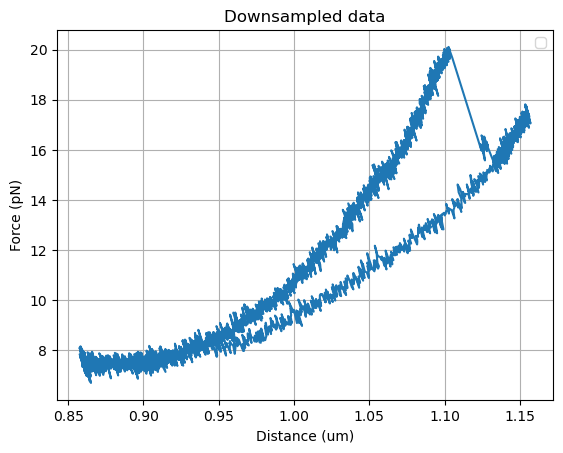

In [195]:
s = 0
e = len(distance_5_downsamp)
plt.plot(distance_5_downsamp.data[s:e-3200], force_5_downsamp.data[s:e-3200])
plt.ylabel('Force (pN)')
plt.xlabel('Distance (um)')
plt.title('Downsampled data')


plt.legend()
plt.grid()

In [206]:

tether_length_rv_data = distance_5_downsamp.data[s:e//2-50]
force_data_rv_data = force_5_downsamp.data[s:e//2-50]

force_back_folded = force_data_rv_data[(tether_length_rv_data < folded_max) & (tether_length_rv_data > folded_min)]
distance_back_folded = tether_length_rv_data[(tether_length_rv_data < folded_max) & (tether_length_rv_data > folded_min)]

force_back_unfolded = force_data_rv_data[(tether_length_rv_data < unfolded_max) & (tether_length_rv_data > unfolded_min)]
distance_back_unfolded = tether_length_rv_data[(tether_length_rv_data < unfolded_max) & (tether_length_rv_data > unfolded_min)]

force_step = force_data_rv_data[(tether_length_rv_data < unfolded_min) & (tether_length_rv_data > folded_max)]
distance_step = tether_length_rv_data[(tether_length_rv_data < unfolded_min) & (tether_length_rv_data > folded_max)]

In [213]:
# Model of the dna handles  for the FD curve portion with folded hairpin
dna_handles_model = lk.ewlc_odijk_force("dna_handles") + lk.force_offset("dna_handles")

# Model for the FD curve with unfolded hairpin, assuming the unfolded hairpin behaves like ssDNA (freely jointed chain)
composite_model_as_function_of_force = lk.ewlc_odijk_distance("dna_handles") + lk.efjc_distance("rna_ss_hairpin")

# the model with force as a function of distance
composite_model = composite_model_as_function_of_force.invert(interpolate=True, independent_min=0, independent_max=90) + lk.force_offset("dna_handles")

fit = lk.FdFit(dna_handles_model, composite_model)

# Add data to the fit:
fit[dna_handles_model].add_data("DNA handles",force_back_folded,distance_back_folded)

fit[composite_model].add_data("DNA handles + unfolded hairpin",force_back_unfolded,distance_back_unfolded)

fit.fit()

C:\Users\Mariia\anaconda3\envs\pylake\lib\site-packages\lumicks\pylake\fitting\fit.py:271: RuntimeWarning: invalid value encountered in sqrt
  self.params[name].stderr = np.sqrt(value)


Name,Value,Unit,Fitted,Lower bound,Upper bound
dna_handles/Lp,0.873717,[nm],True,0.001,100
dna_handles/Lc,1.47067,[micron],True,0.00034,inf
dna_handles/St,1.12399e+09,[pN],True,1,inf
kT,4.11,[pN*nm],False,3.77,8
dna_handles/f_offset,0.1,[pN],True,-0.1,0.1
rna_ss_hairpin/Lp,0.239067,[nm],True,0.001,100
rna_ss_hairpin/Lc,0.130343,[micron],True,0.00034,inf
rna_ss_hairpin/St,2.40935e+07,[pN],True,1,inf


In [214]:
fit["dna_handles/Lp"].lower_bound = 0.5 # in nanometers # typical persistance length for ssDNA
fit["dna_handles/Lp"].value = 0.873717 # typical persistance length for dsDNA

fit["rna_ss_hairpin/Lp"].lower_bound = 0.1 # in nanometers
fit["rna_ss_hairpin/Lp"].value = 0.239067 # in nanometers
fit["rna_ss_hairpin/Lp"].upper_bound = 2.0 # in nanometers

fit["rna_ss_hairpin/Lc"].value = 0.130343 # in microns
fit["rna_ss_hairpin/Lc"].lower_bound = 0.001 # in microns

fit["rna_ss_hairpin/St"].value = 500 # in pN
fit["rna_ss_hairpin/St"].upper_bound = 2000 # in pN

fit["dna_handles/f_offset"].lower_bound = -0.2 # in pN
fit["dna_handles/f_offset"].value = 0 # in pN
fit["dna_handles/f_offset"].upper_bound = 0.2 # in pN 

#fit:
# fit.fit()
# you fit the first, folded part on dsDNA and the second, unfolded part on ssDNA
# the output parameters you can check and compare to what you expect, if it doesnt fit at all, f.i. the persistence length, you woukld know when you had multiple tethers
# calculation takes a while

Hairpin length in ssRNA is 124.704027539692 nm


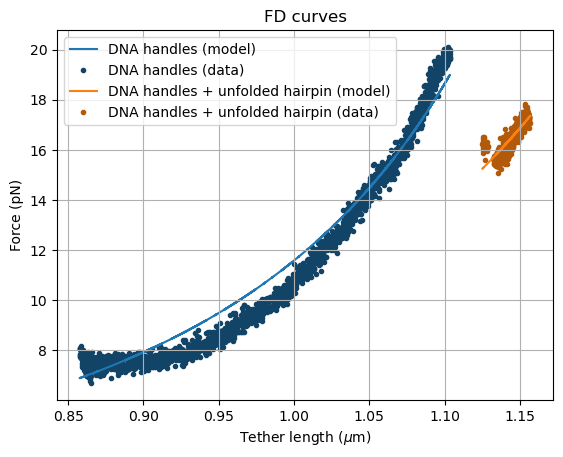

In [402]:

plt.figure()
# plt.scatter(tether_length_rv_data, force_data_rv_data,s=2,c='grey',alpha=0.2,label='FD back')
fit[dna_handles_model].plot()
fit[composite_model].plot()
plt.title('FD curves')
plt.xlabel(r'Tether length ($\mu$m)')
plt.ylabel('Force (pN)')
# plt.legend()
plt.grid()
#plt.xlim([1.6,1.77])
#plt.savefig('control hairpin FD fitting bp9_Fd1_try2 back.pdf')

print(f'Hairpin length in ssRNA is {fit["rna_ss_hairpin/Lc"].value*1000} nm')

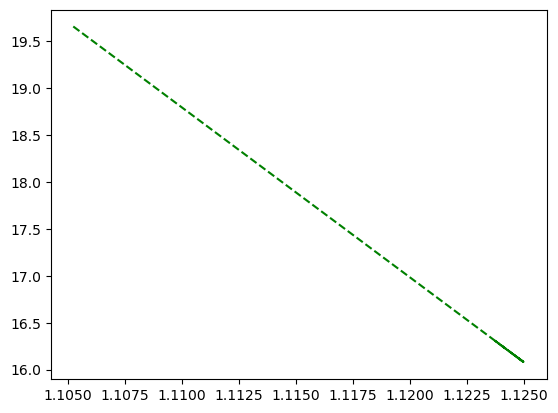

In [220]:
# find approximation of W_step
# plt.scatter(tether_length_rv_data[:len(force_data_rv_data)-180], force_data_rv_data[:len(force_data_rv_data)-180])
# plt.scatter(distance_step, force_step, c = 'r')
def func(x, a, b):
    return b + a*x 

popt, pcov = curve_fit(func, distance_step, force_step)
plt.plot(distance_step, func(distance_step, *popt), 'g--')

In [228]:
fit.fit()

Name,Value,Unit,Fitted,Lower bound,Upper bound
dna_handles/Lp,0.894315,[nm],True,0.5,100
dna_handles/Lc,1.466,[micron],True,0.00034,inf
dna_handles/St,9.45013e+09,[pN],True,1,inf
kT,4.11,[pN*nm],False,3.77,8
dna_handles/f_offset,0.2,[pN],True,-0.2,0.2
rna_ss_hairpin/Lp,0.247625,[nm],True,0.1,2
rna_ss_hairpin/Lc,0.124704,[micron],True,0.001,inf
rna_ss_hairpin/St,619.971,[pN],True,1,2000


W_ds 3.572042210779622 1e-18 J
W_ss 3.0263519170417728 1e-18 J
W_step 0.3594262554424392 1e-18 J
Work_structure 0.9051165491802884 1e-18 J
Work_structure 130.3229281527227 kcal/mol


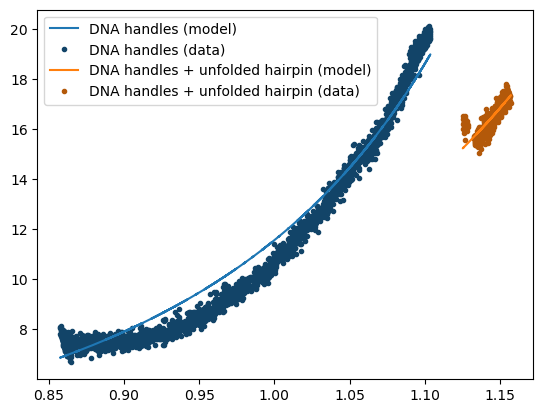

In [396]:
# Definite integral of y = n-dimensional array as approximated along a single axis by the trapezoidal rule.
distance = np.arange(0.7, 1.105, 0.001)
force = dna_handles_model(distance, {"dna_handles/Lp": 0.894315, "dna_handles/Lc":  1.466, "dna_handles/St": 9.45013e+09, "kT": 4.11, "dna_handles/f_offset": -0.0630843})
# plt.plot(distance,force, label = 'WLC')
fit[dna_handles_model].plot()
w_ds = np.trapz(force, dx = 0.001)
print('W_ds', w_ds, 1e-18,  'J')


distance1 = np.arange(0.7, 1.105, 0.001)
force1 = composite_model(distance1, {"dna_handles/Lp": 0.894315, "dna_handles/Lc":  1.466, "dna_handles/St": 9.45013e+09, "kT": 4.11, "dna_handles/f_offset": -0.0630843, "rna_ss_hairpin/Lp": 0.247625, "rna_ss_hairpin/Lc": 0.124704, "rna_ss_hairpin/St": 619.971, "kT": 4.11, "dna_handles/f_offset": -0.0630843})
fit[composite_model].plot()
# plt.plot(distance1,force1, label = 'WLC+FJC')
w_ss = np.trapz(force1, dx = 0.001)
print('W_ss', w_ss,  1e-18,  'J')

distance2 = np.arange(1.105, 1.125, 0.001)
w_step = np.trapz(func(distance2, *popt), dx = 0.001)
print('W_step', w_step,  1e-18,  'J')

print('Work_structure', w_ds-w_ss + w_step, 1e-18,  'J')
print('Work_structure', (w_ds-w_ss + w_step)* 6.02/4181*10**5, 'kcal/mol')

## We could not use model of WLC + FJC, becuase we have protein binding to rna

19.66550116901147 1.1052302967708607


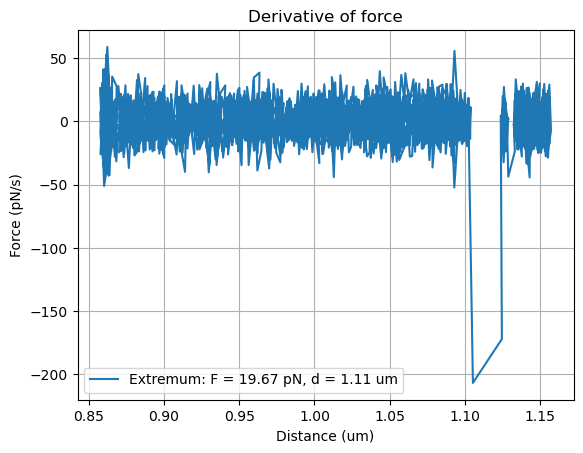

In [224]:
# find force of transition
d_5_down = distance_5_downsamp.data[s:e//2-50]
f_5_down = force_5_downsamp.data[s:e//2-50]
time_5 = time_downsampled[s:e//2-50]

deriv = np.gradient(f_5_down, time_5)
# plt.plot(d_down[bs_:es_//3], f_down[bs_:es_//3])

plt.plot(d_5_down, deriv, label = 'Extremum: F = 19.67 pN, d = 1.11 um')
plt.ylabel('Force (pN/s)')
plt.xlabel('Distance (um)')
plt.title('Derivative of force')


def implicit(l):
    min_idx, min_val = min(enumerate(l), key=operator.itemgetter(1))
    return min_idx, min_val
ind_derf, val_derf = implicit(deriv)

plt.legend()
plt.grid()

print(f_5_down[ind_derf], d_5_down[ind_derf])

W_ds 5.711066112179136 1e-18 J


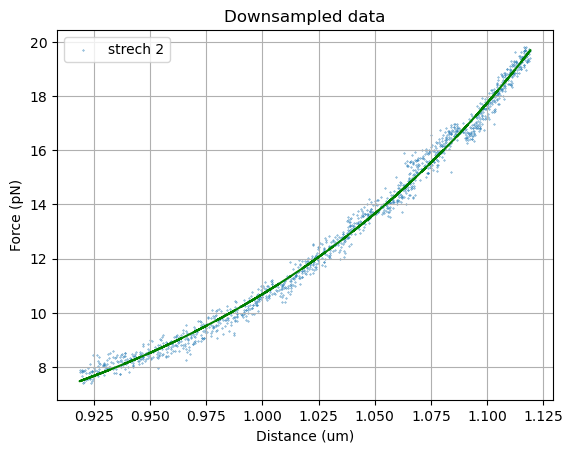

In [464]:
def func(x, m, t, b):
    return m * np.exp(-t * x) + b

popt, pcov = curve_fit(func, distance_5_downsamp.data[p1:e-1879],  force_5_downsamp.data[p1:e-1879])
plt.plot(distance_5_downsamp.data[p1:e-1879], func(distance_5_downsamp.data[p1:e-1879], *popt), 'g')
s = 0
e = len(distance_5_downsamp)
plt.scatter(distance_5_downsamp.data[p1:e-1879], force_5_downsamp.data[p1:e-1879], s= 0.1, alpha = 1,  label = 'strech 2')
plt.ylabel('Force (pN)')
plt.xlabel('Distance (um)')
plt.title('Downsampled data')

p2 = e-1879
plt.legend()
plt.grid()

distance1 = np.arange(0, 1.12, 0.001)
w_ds = np.trapz(func(distance1, *popt), dx = 0.001)
print('W_ds', w_ds, 1e-18,  'J')

W_ss 7.105367980314408 1e-18 J


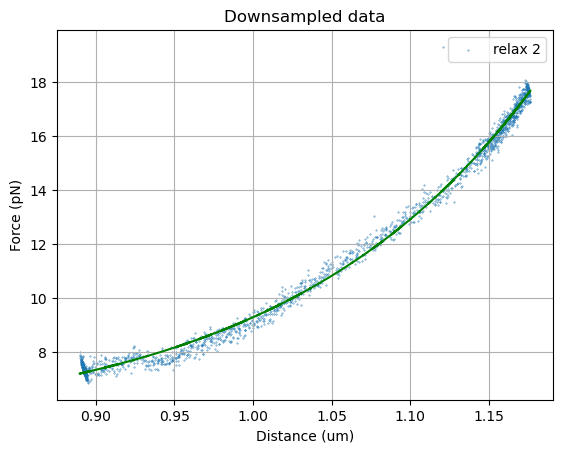

In [467]:
def func(x, m, t, b):
    return m * np.exp(-t * x) + b

popt, pcov = curve_fit(func, distance_5_downsamp.data[p2+80:e],  force_5_downsamp.data[p2+80:e])
plt.plot(distance_5_downsamp.data[p2+80:e], func(distance_5_downsamp.data[p2+80:e], *popt), 'g')
s = 0
e = len(distance_5_downsamp)
plt.scatter(distance_5_downsamp.data[p2:e], force_5_downsamp.data[p2:e],  s= 0.1, alpha = 1, label = 'relax 2')
plt.ylabel('Force (pN)')
plt.xlabel('Distance (um)')
plt.title('Downsampled data')


plt.legend()
plt.grid()

distance1 = np.arange(0, 1.12, 0.001)
w_ss = np.trapz(func(distance1, *popt), dx = 0.001)
print('W_ss', w_ss, 1e-18,  'J')

W_ds 5.711066112179136 1e-18 J
W_ss 7.105367980314408 1e-18 J
W_step 1.2315010730040652 1e-18 J
W_structure -0.1628007951312065 1e-18 J
Work_structure -23.440822451324156 kcal/mol


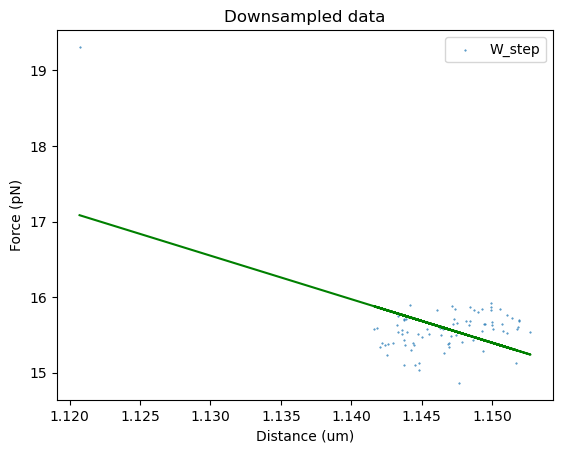

In [468]:
def func(x, a, b):
    return a* x + b

popt, pcov = curve_fit(func, distance_5_downsamp.data[e-1879:p2+80],  force_5_downsamp.data[e-1879:p2+80])
plt.plot(distance_5_downsamp.data[e-1879:p2+80], func(distance_5_downsamp.data[e-1879:p2+80], *popt), 'g')

s = 0
e = len(distance_5_downsamp)
plt.scatter(distance_5_downsamp.data[e-1879:p2+80], force_5_downsamp.data[e-1879:p2+80],s = 0.2, alpha = 1, label = 'W_step')
plt.ylabel('Force (pN)')
plt.xlabel('Distance (um)')
plt.title('Downsampled data')

p1 = e-3200
plt.legend()
plt.grid()

plt.legend()
plt.grid()
w_step = np.trapz(func(distance_5_downsamp.data[e-1879:p2+80], *popt), dx = 0.001)

print('W_ds', w_ds, 1e-18,  'J')
print('W_ss', w_ss, 1e-18,  'J')
print('W_step', w_step, 1e-18,  'J')

print('W_structure', w_ds-w_ss +w_step, 1e-18,  'J')
print('Work_structure', (w_ds-w_ss + w_step)* 6.02/4181*10**5, 'kcal/mol')

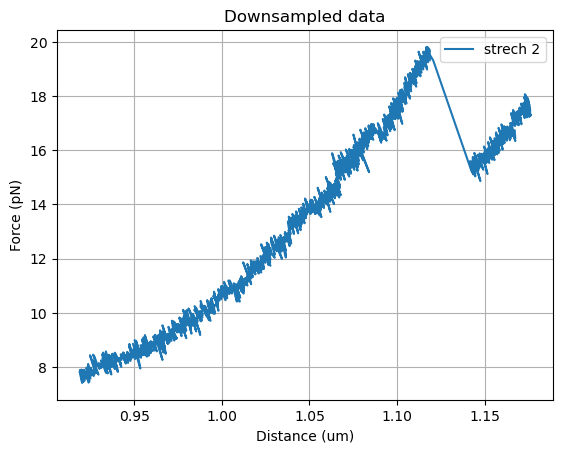

In [68]:
s = 0
e = len(distance_5_downsamp)
plt.plot(distance_5_downsamp.data[p1:e-1500], force_5_downsamp.data[p1:e-1500], label = 'strech 2')
plt.ylabel('Force (pN)')
plt.xlabel('Distance (um)')
plt.title('Downsampled data')

p2 = e-1300
plt.legend()
plt.grid()

In [470]:
258*6.02

1553.1599999999999

19.31159760430746 1.1207105994818576


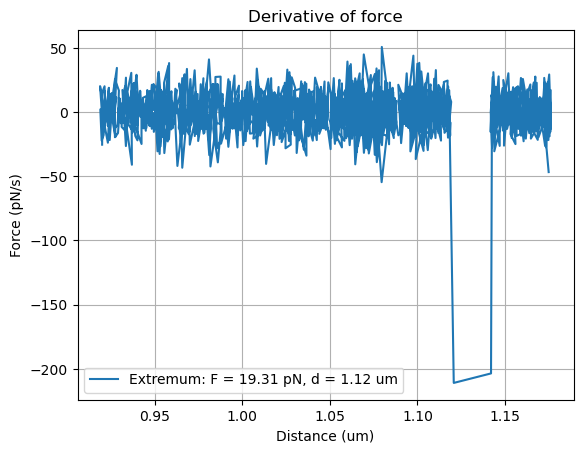

In [135]:
# find force of transition
d_5_down = distance_5_downsamp.data[p1:e-1500]
f_5_down = force_5_downsamp.data[p1:e-1500]
time_5 = time_downsampled[p1:e-1500]

deriv = np.gradient(f_5_down, time_5)
# plt.plot(d_down[bs_:es_//3], f_down[bs_:es_//3])

plt.plot(d_5_down, deriv, label = 'Extremum: F = 19.31 pN, d = 1.12 um')
plt.ylabel('Force (pN/s)')
plt.xlabel('Distance (um)')
plt.title('Derivative of force')


def implicit(l):
    min_idx, min_val = min(enumerate(l), key=operator.itemgetter(1))
    return min_idx, min_val
ind_derf, val_derf = implicit(deriv)

plt.legend()
plt.grid()

print(f_5_down[ind_derf], d_5_down[ind_derf])

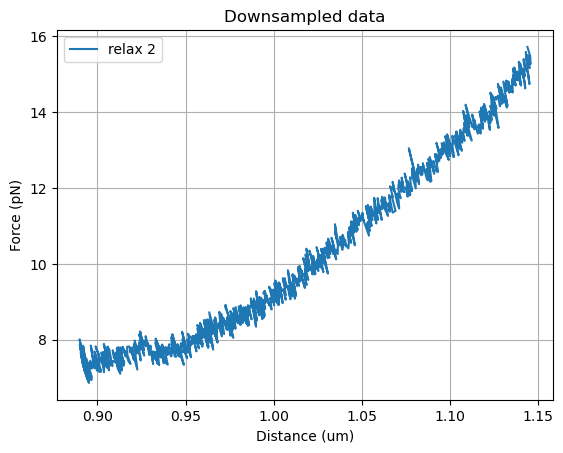

In [133]:
s = 0
e = len(distance_5_downsamp)
plt.plot(distance_5_downsamp.data[p2:e], force_5_downsamp.data[p2:e], label = 'relax 2')
plt.ylabel('Force (pN)')
plt.xlabel('Distance (um)')
plt.title('Downsampled data')


plt.legend()
plt.grid()

In [314]:
dis_str, for_str = cutout_first_stretch([distance_5_downsamp.data, force_5_downsamp.data])
dis_rel, for_rel = cutout_first_relax([distance_5_downsamp.data, force_5_downsamp.data])

d_str, f_str = zip(*sorted(zip(dis_str, for_str)))
cs_str = CubicSpline(d_str, f_str)

d_rel, f_rel = zip(*sorted(zip(dis_rel, for_rel)))
cs_rel = CubicSpline(d_rel, f_rel)


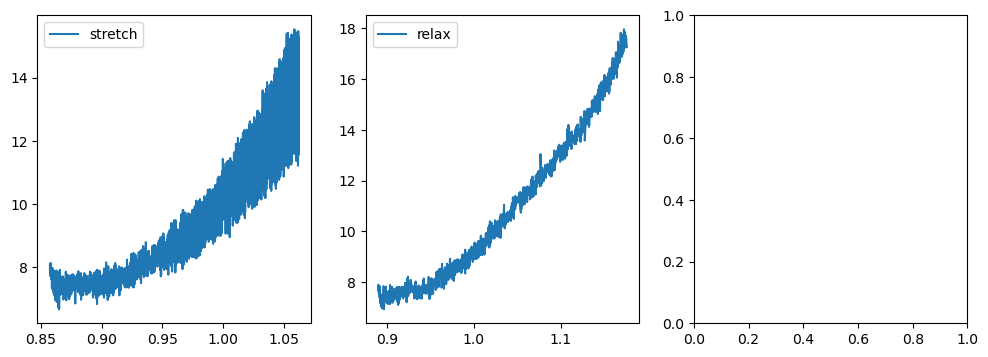

In [316]:
# fig, ax = plt.subplots(ncols=3, figsize=(12,4))

# co_str = 4500
# co_rel = 0

# ax[0].plot(d_str[:co_str], cs_str(d_str)[:co_str], label='stretch')
# ax[0].legend()


# ax[1].plot(d_rel[co_rel:], cs_rel(d_rel)[co_rel:], label='relax')

# ax[1].legend()




In [19]:
force_6 = file6['Force HF']['Corrected Force 2x']
distance_6 = file6['Distance']['Piezo Distance']

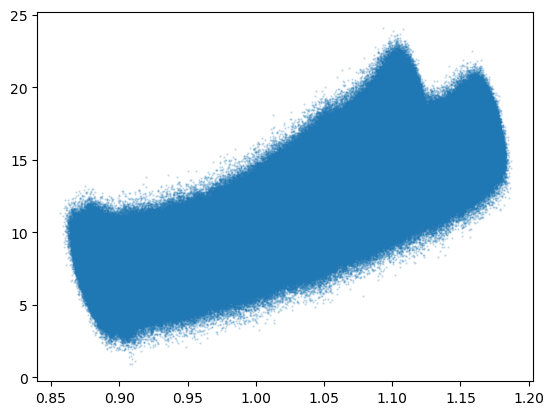

In [20]:
plt.scatter(distance_6.data, force_6.data, s=0.5, alpha=0.2, label = 'raw data')

In [114]:
downsampled_rate = 100 # Hz
sample_rate = force_6.sample_rate

time = (force_6.timestamps - force_6.timestamps[0]) /1e9
force_6_downsamp1 = force_6.downsampled_by(int(sample_rate/downsampled_rate))
time_downsampled = (force_6_downsamp.timestamps- force_6_downsamp.timestamps[0]) /1e9

time_d = (distance_6.timestamps- distance_6.timestamps[0]) /1e9
distance_6_downsamp1 = distance_6.downsampled_by(int(sample_rate/downsampled_rate))
time_downsampled_d = (distance_6_downsamp.timestamps- distance_6_downsamp.timestamps[0]) /1e9

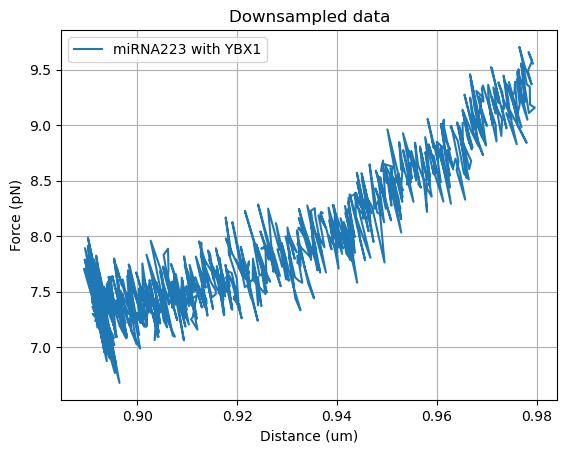

In [328]:
plt.plot(distance_6_downsamp1.data[bs:es//3], force_6_downsamp1.data[bs:es//3], label = 'miRNA223 with YBX1')
plt.ylabel('Force (pN)')
plt.xlabel('Distance (um)')
plt.title('Downsampled data')


plt.legend()
plt.grid()

In [21]:
force_7 = file7['Force HF']['Corrected Force 2x']
distance_7 = file7['Distance']['Piezo Distance']

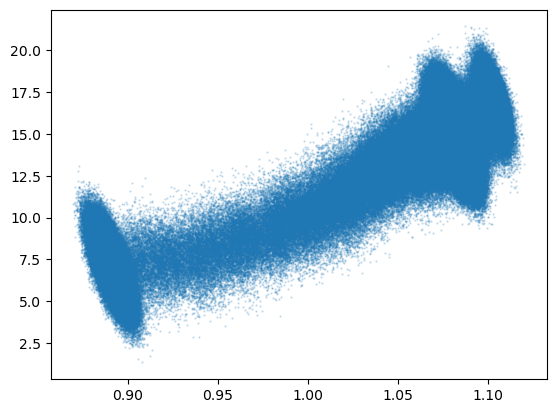

In [123]:
#approach curve
plt.scatter(distance_7.data[start:end], force_7.data[start:end], s=0.5, alpha=0.2, label = 'raw data')

In [124]:
downsampled_rate = 100 # Hz
sample_rate = force_7.sample_rate

time = (force_7.timestamps - force_7.timestamps[0]) /1e9
force_7_downsamp = force_7.downsampled_by(int(sample_rate/downsampled_rate))
time_downsampled = (force_7_downsamp.timestamps- force_7_downsamp.timestamps[0]) /1e9

time_d = (distance_7.timestamps- distance_7.timestamps[0]) /1e9
distance_7_downsamp = distance_7.downsampled_by(int(sample_rate/downsampled_rate))
time_downsampled_d = (distance_7_downsamp.timestamps- distance_7_downsamp.timestamps[0]) /1e9

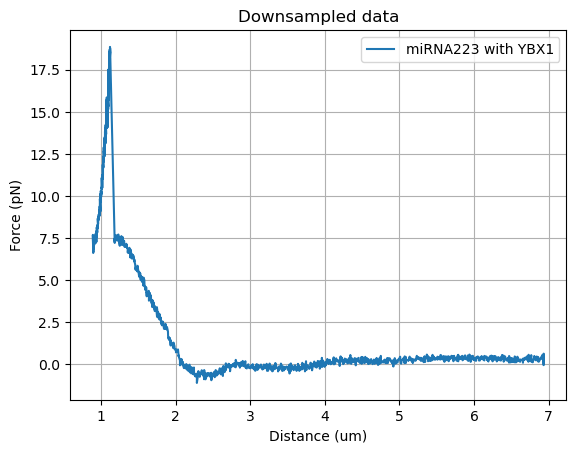

In [131]:
e = len(distance_7_downsamp.data)
plt.plot(distance_7_downsamp.data, force_7_downsamp.data, label = 'miRNA223 with YBX1')
plt.ylabel('Force (pN)')
plt.xlabel('Distance (um)')
plt.title('Downsampled data')


plt.legend()
plt.grid()

In [ ]:
downsampled_rate = 100 # Hz
sample_rate = force_7.sample_rate

time = (force_7.timestamps - force_7.timestamps[0]) /1e9
force_7_downsamp = force_7.downsampled_by(int(sample_rate/downsampled_rate))
time_downsampled = (force_7_downsamp.timestamps- force_7_downsamp.timestamps[0]) /1e9

time_d = (distance_7.timestamps- distance_7.timestamps[0]) /1e9
distance_7_downsamp = distance_7.downsampled_by(int(sample_rate/downsampled_rate))
time_downsampled_d = (distance_7_downsamp.timestamps- distance_7_downsamp.timestamps[0]) /1e9

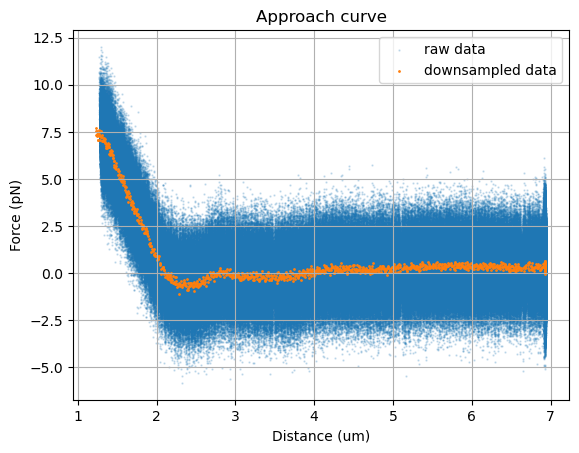

In [181]:
ed1 = len(distance_7.data)
plt.scatter(distance_7.data[ed1-9950000:], force_7.data[ed1-9950000:], s=0.5, alpha=0.2, label = 'raw data')
ed2 = len(distance_7_downsamp)
plt.scatter(distance_7_downsamp.data[ed2-1400:], force_7_downsamp.data[ed2-1400:],s=1, alpha=1, label = 'downsampled data')
plt.ylabel('Force (pN)')
plt.xlabel('Distance (um)')
plt.title('Approach curve')


plt.legend()
plt.grid()


In [ ]:
downsampled_rate = 100 # Hz
sample_rate = force_5.sample_rate

time = (force_5.timestamps - force_5.timestamps[0]) /1e9
force_5_downsamp = force_5.downsampled_by(int(sample_rate/downsampled_rate))
time_downsampled = (force_5_downsamp.timestamps- force_5_downsamp.timestamps[0]) /1e9

time_d = (distance_5.timestamps- distance_5.timestamps[0]) /1e9
distance_5_downsamp = distance_5.downsampled_by(int(sample_rate/downsampled_rate))
time_downsampled_d = (distance_5_downsamp.timestamps- distance_5_downsamp.timestamps[0]) /1e9

# miRNA223 without YBX1

In [107]:
start = 0
end = s//4-100000

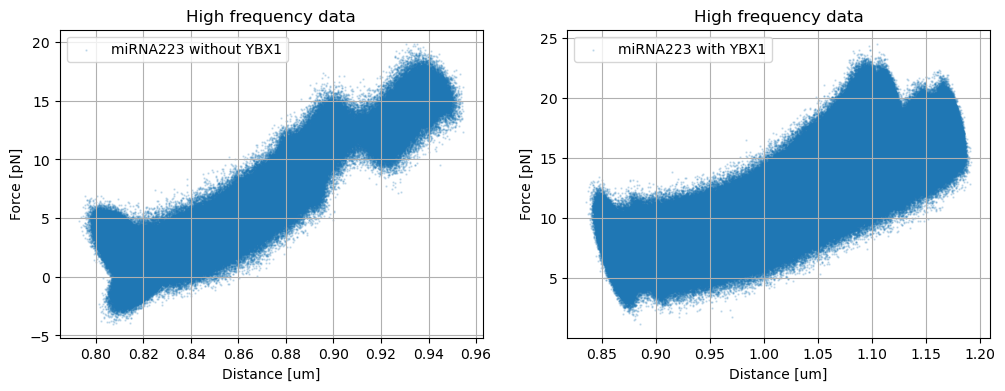

In [109]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ax[0].scatter(d11, f11,s=0.5, alpha=0.2, label = 'miRNA223 without YBX1')
ax[0].set_title('High frequency data')
ax[0].set_ylabel('Force [pN]')
ax[0].set_xlabel('Distance [um]')

ax[1].scatter(distance_5.data, force_5.data, s=0.5, alpha=0.2, label = 'miRNA223 with YBX1')
ax[1].set_title('High frequency data')
ax[1].set_ylabel('Force [pN]')
ax[1].set_xlabel('Distance [um]')

for i in range(2):
    ax[i].legend()
    ax[i].grid()

# Downsampled data

In [22]:
downsampled_rate1 = 100 # Hz
sample_rate1 = force_5.sample_rate

time1 = (force_5.timestamps - force_5.timestamps[0]) /1e9
force_5_downsamp1 = force_5.downsampled_by(int(sample_rate1/downsampled_rate1))
time_downsampled1 = (force_5_downsamp1.timestamps- force_5_downsamp1.timestamps[0]) /1e9

time_d1 = (distance_5.timestamps- distance_5.timestamps[0]) /1e9
distance_5_downsamp1 = distance_5.downsampled_by(int(sample_rate1/downsampled_rate1))
time_downsampled_d1 = (distance_5_downsamp1.timestamps- distance_5_downsamp1.timestamps[0]) /1e9

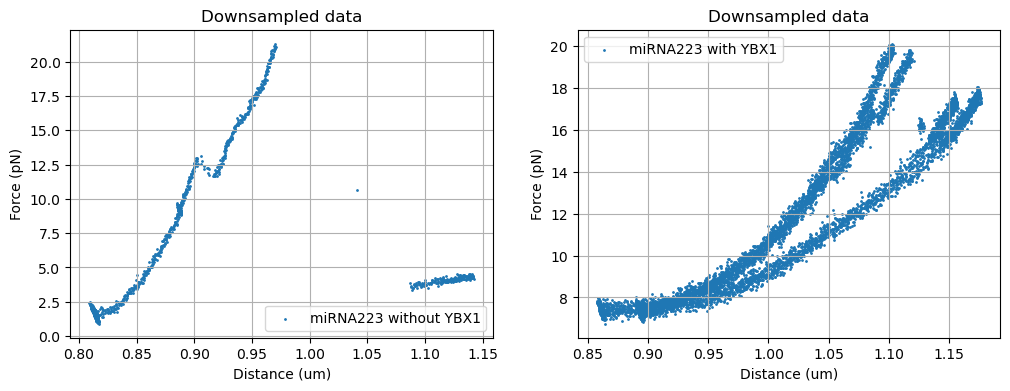

In [333]:
es = len(distance_1_11_downsamp)
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
# plt.plot(d_down[bs_:es_//3], f_down[bs_:es_//3])
ax[0].scatter(distance_1_11_downsamp.data[bs:es//3], force_2x_11_downsamp.data[bs:es//3],s=1, alpha=1, label = 'miRNA223 without YBX1')
ax[0].set_ylabel('Force (pN)')
ax[0].set_xlabel('Distance (um)')
ax[0].set_title('Downsampled data')

ax[1].scatter(distance_5_downsamp1.data[bs:es//2], force_5_downsamp1.data[bs:es//2],s=1, alpha=1, label = 'miRNA223 with YBX1')
ax[1].set_ylabel('Force (pN)')
ax[1].set_xlabel('Distance (um)')
ax[1].set_title('Downsampled data')


for i in range(2):
    ax[i].legend()
    ax[i].grid()



In [334]:
distance_5_downsamp1

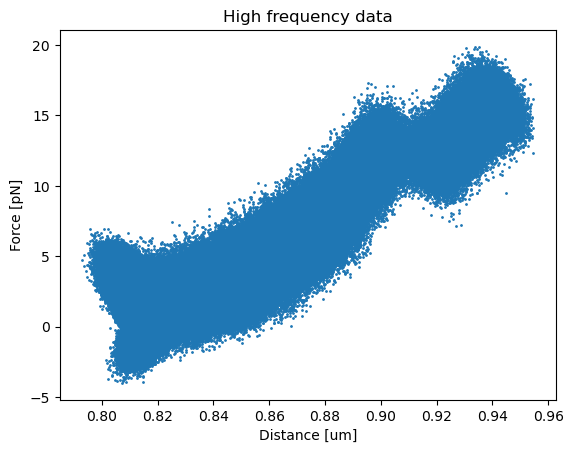

In [91]:
plt.scatter(distance_1_11.data[start:end], force_2x_11.data[start:end],s=1, alpha=1, label = 'raw data')
plt.title('High frequency data')
plt.ylabel('Force [pN]')
plt.xlabel('Distance [um]')
plt.show()

# Trap stiffnes

In [27]:
# fd 5 with YBX1
ky5 = file5.force1y.calibration[0]["kappa (pN/nm)"]
kx5 = file5.force1x.calibration[0]["kappa (pN/nm)"]
print(ky5) # this is in pN/nm
print(kx5) # this is in pN/nm

0.36225142430572765
0.325867187650975


In [25]:
# fd 11 - single tether
ky11 = file11.force1y.calibration[0]["kappa (pN/nm)"]
kx11 = file11.force1x.calibration[0]["kappa (pN/nm)"]
print(ky11) # this is in pN/nm
print(kx11) # this is in pN/nm

0.3299632582153117
0.3547664270119453


# Fitting

## hairpin of mir223

In [454]:
folded_min = 0.82  #lower lim (in um) for FD11 curve with folded hairpin
folded_max = 0.905 #upper lim (in um) for FD11 curve with folded hairpin
unfolded_min = 0.914  #lower lim (in um) for FD11 curve with unfolded hairpin
unfolded_max = 0.99 #upper lim (in um) for FD11 curve with unfolded hairpin


In [455]:

tether_length_rv_data = distance_1_11_downsamp.data[bs:es//3-300]
force_data_rv_data = force_2x_11_downsamp.data[bs:es//3-300]

force_back_folded = force_data_rv_data[(tether_length_rv_data < folded_max) & (tether_length_rv_data > folded_min)]
distance_back_folded = tether_length_rv_data[(tether_length_rv_data < folded_max) & (tether_length_rv_data > folded_min)]

force_back_unfolded = force_data_rv_data[(tether_length_rv_data < unfolded_max) & (tether_length_rv_data > unfolded_min)]
distance_back_unfolded = tether_length_rv_data[(tether_length_rv_data < unfolded_max) & (tether_length_rv_data > unfolded_min)]

force_step = force_data_rv_data[(tether_length_rv_data < unfolded_min) & (tether_length_rv_data > folded_max)]
distance_step = tether_length_rv_data[(tether_length_rv_data < unfolded_min) & (tether_length_rv_data > folded_max)]


Text(0.5, 0, 'Distance ($\\mu$m)')

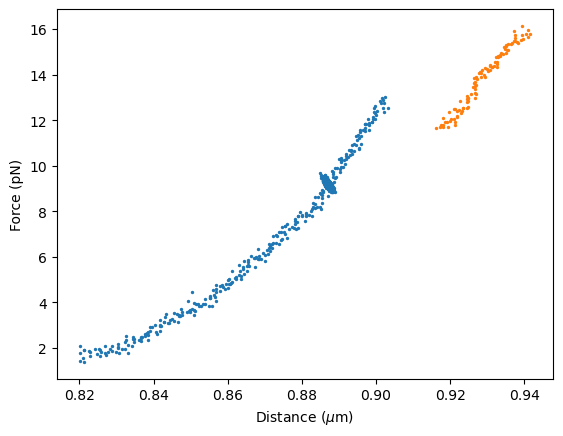

In [456]:
plt.figure()
plt.scatter(distance_back_folded, force_back_folded,s=2,alpha=1,label='Selection folded')
plt.scatter(distance_back_unfolded, force_back_unfolded,s=2,alpha=1,label='Selection unfolded')
plt.ylabel('Force (pN)')
plt.xlabel('Distance ($\mu$m)')

# Define a model


In [457]:
# Model of the dna handles  for the FD curve portion with folded hairpin
dna_handles_model = lk.ewlc_odijk_force("dna_handles") + lk.force_offset("dna_handles")

# Model for the FD curve with unfolded hairpin, assuming the unfolded hairpin behaves like ssDNA (freely jointed chain)
composite_model_as_function_of_force = lk.ewlc_odijk_distance("dna_handles") + lk.efjc_distance("rna_ss_hairpin")

# the model with force as a function of distance
composite_model = composite_model_as_function_of_force.invert(interpolate=True, independent_min=0, independent_max=90) + lk.force_offset("dna_handles")

fit = lk.FdFit(dna_handles_model, composite_model)

# Add data to the fit:
fit[dna_handles_model].add_data("DNA handles",force_back_folded,distance_back_folded)

fit[composite_model].add_data("DNA handles + unfolded hairpin",force_back_unfolded,distance_back_unfolded)

FitData(DNA handles + unfolded hairpin, N=99)

# Set parametrs

In [458]:
fit["dna_handles/Lp"].lower_bound = 10 # in nanometers # typical persistance length for ssDNA
fit["dna_handles/Lp"].value = 50 # typical persistance length for dsDNA

fit["rna_ss_hairpin/Lp"].lower_bound = 0.5 # in nanometers
fit["rna_ss_hairpin/Lp"].value = 1 # in nanometers
fit["rna_ss_hairpin/Lp"].upper_bound = 2.0 # in nanometers

fit["rna_ss_hairpin/Lc"].value = 0.02 # in microns
fit["rna_ss_hairpin/Lc"].lower_bound = 0.001 # in microns

fit["rna_ss_hairpin/St"].value = 500 # in pN
fit["rna_ss_hairpin/St"].upper_bound = 2000 # in pN

fit["dna_handles/f_offset"].lower_bound = -0.2 # in pN
fit["dna_handles/f_offset"].value = 0 # in pN
fit["dna_handles/f_offset"].upper_bound = 0.2 # in pN 

#fit:
fit.fit()
# you fit the first, folded part on dsDNA and the second, unfolded part on ssDNA
# the output parameters you can check and compare to what you expect, if it doesnt fit at all, f.i. the persistence length, you woukld know when you had multiple tethers
# calculation takes a while

Name,Value,Unit,Fitted,Lower bound,Upper bound
dna_handles/Lp,71.1562,[nm],True,10,100
dna_handles/Lc,0.892541,[micron],True,0.00034,inf
dna_handles/St,285.345,[pN],True,1,inf
kT,4.11,[pN*nm],False,3.77,8
dna_handles/f_offset,-0.2,[pN],True,-0.2,0.2
rna_ss_hairpin/Lp,2,[nm],True,0.5,2
rna_ss_hairpin/Lc,0.00924703,[micron],True,0.001,inf
rna_ss_hairpin/St,9.58719,[pN],True,1,2000


Hairpin length in ssRNA is 9.24703260026663 nm


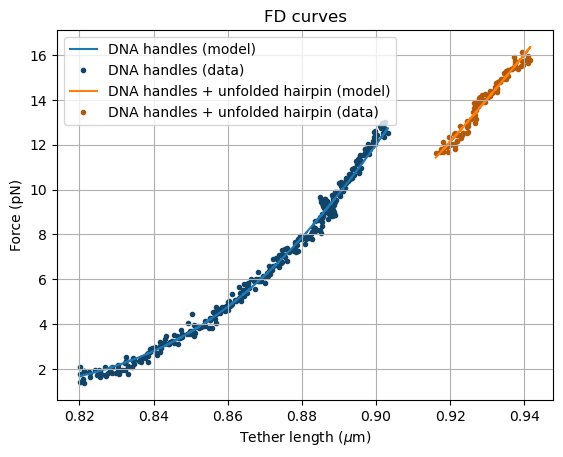

In [459]:
plt.figure()
# plt.scatter(tether_length_rv_data, force_data_rv_data,s=2,c='grey',alpha=0.2,label='FD back')
fit[dna_handles_model].plot()
fit[composite_model].plot()
plt.title('FD curves')
plt.xlabel(r'Tether length ($\mu$m)')
plt.ylabel('Force (pN)')
# plt.legend()
plt.grid()
#plt.xlim([1.6,1.77])
#plt.savefig('control hairpin FD fitting bp9_Fd1_try2 back.pdf')

print(f'Hairpin length in ssRNA is {fit["rna_ss_hairpin/Lc"].value*1000} nm')
# plot takes a while

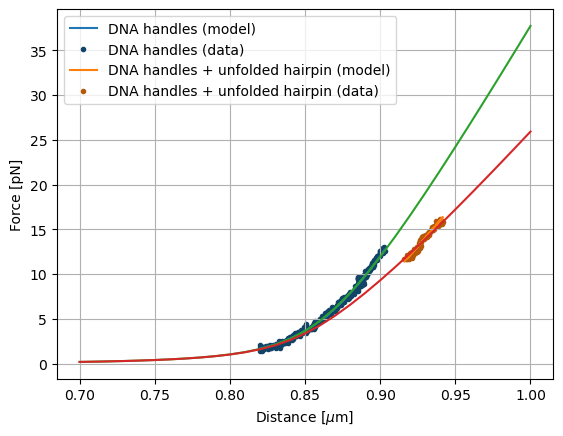

In [480]:
plt.figure()
fit[dna_handles_model].plot()
fit[composite_model].plot()
distance = np.arange(0.7, 1., 0.01)
force = dna_handles_model(distance, {"dna_handles/Lp": 91.7158, "dna_handles/Lc":  0.886089, "dna_handles/St": 259.146, "kT": 4.11, "dna_handles/f_offset": -0.0630843})

distance1 = np.arange(0.7, 1, 0.01)
force1 = composite_model(distance1, {"dna_handles/Lp": 91.7158, "dna_handles/Lc":  0.886089, "dna_handles/St": 259.146, "kT": 4.11, "dna_handles/f_offset": -0.0630843, "rna_ss_hairpin/Lp": 0.5, "rna_ss_hairpin/Lc": 0.00457022, "rna_ss_hairpin/St": 2.51996, "kT": 4.11, "dna_handles/f_offset": -0.0630843})

plt.plot(distance,force)
plt.plot(distance1,force1)

plt.ylabel("Force [pN]")
plt.xlabel("Distance [$\\mu$m]")
plt.legend()
plt.grid()
plt.show()

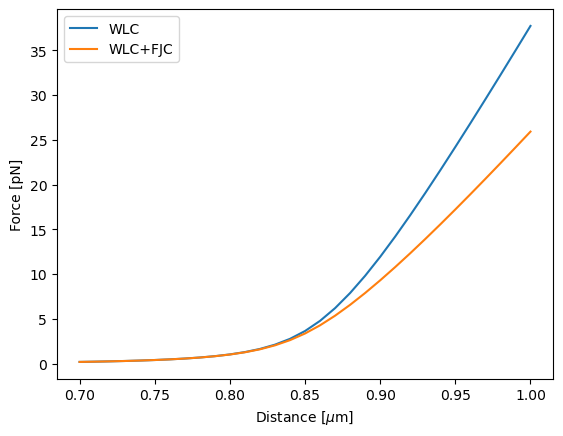

In [449]:
plt.plot(distance, force, label = 'WLC')
plt.plot(distance1,force1, label = 'WLC+FJC')

plt.ylabel("Force [pN]")
plt.xlabel("Distance [$\\mu$m]")
plt.legend()
plt.show()

# Calculate work of structure (mir223)

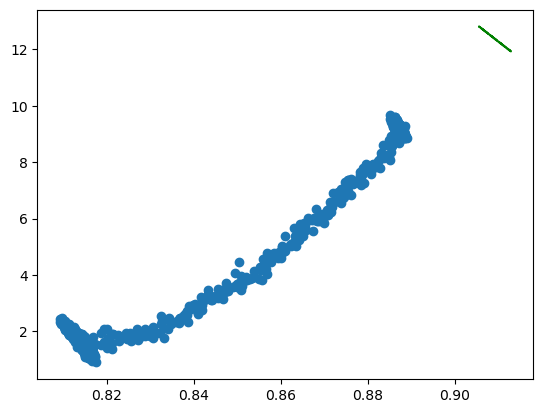

In [190]:
# find approximation of W_step
plt.scatter(tether_length_rv_data[:len(force_data_rv_data)-180], force_data_rv_data[:len(force_data_rv_data)-180])
# plt.scatter(distance_step, force_step, c = 'r')
def func1(x, a, b, ):
    return b + a*x 
popt, pcov = curve_fit(func, distance_step, force_step)
plt.plot(distance_step, func(distance_step, *popt), 'g--')


W_ds 12152.754526112472 1e-18 J
W_ss 800.4130571342812 1e-18 J
W_step 0.29346924361814775 1e-18 J
Work_structure 11352.634938221809 1e-18 J
Work_structure 1634605.6524299278 kcal/mol


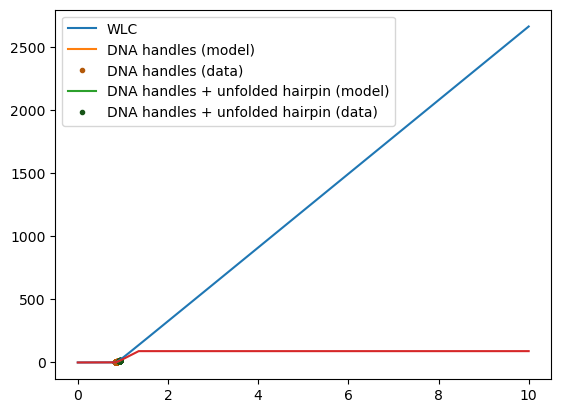

In [482]:
# Definite integral of y = n-dimensional array as approximated along a single axis by the trapezoidal rule.
distance = np.arange(0, 10, 0.001)
force = dna_handles_model(distance, {"dna_handles/Lp": 91.7158, "dna_handles/Lc":  0.886089, "dna_handles/St": 259.146, "kT": 4.11, "dna_handles/f_offset": -0.0630843})
plt.plot(distance,force, label = 'WLC')
fit[dna_handles_model].plot()
w_ds = np.trapz(force, dx = 0.001)
print('W_ds', w_ds, 1e-18,  'J')


distance1 = np.arange(0, 10, 0.001)
force1 = composite_model(distance1, {"dna_handles/Lp": 91.7158, "dna_handles/Lc":  0.886089, "dna_handles/St": 259.146, "kT": 4.11, "dna_handles/f_offset": -0.0630843, "rna_ss_hairpin/Lp": 0.5, "rna_ss_hairpin/Lc": 0.00457022, "rna_ss_hairpin/St": 2.51996, "kT": 4.11, "dna_handles/f_offset": -0.0630843})
fit[composite_model].plot()
plt.plot(distance1,force1, label = 'WLC+FJC')
w_ss = np.trapz(force1, dx = 0.001)
print('W_ss', w_ss,  1e-18,  'J')

distance2 = np.arange(0.903, 0.913, 0.001)
w_step = np.trapz(func(distance2, *popt), dx = 0.001)
print('W_step', w_step,  1e-18,  'J')

print('Work_structure', w_ds-w_ss + w_step, 1e-18,  'J')
print('Work_structure', (w_ds-w_ss + w_step)* 6.02/4181*10**5, 'kcal/mol')

In [450]:
0.20/4181

4.7835446065534565e-05

# Find minimum - define force for unfolding

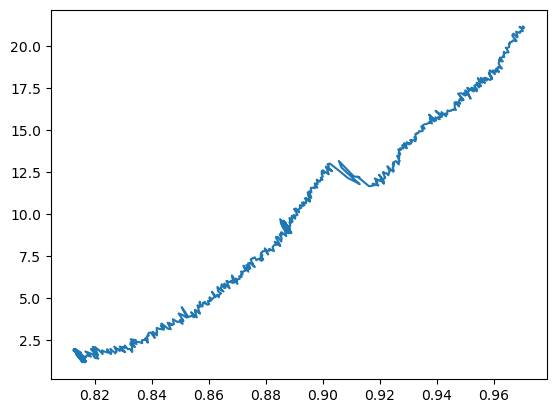

In [474]:
f_11_down = force_2x_11_downsamp.data[bs+3500:es//3-180]
d_11_down = distance_1_11_downsamp.data[bs+3500:es//3-180]
time_11 = time_downsampled[bs+3500:es//3-180]

plt.plot(d_11_down, f_11_down)

12.240637547876165 0.9108011915897213


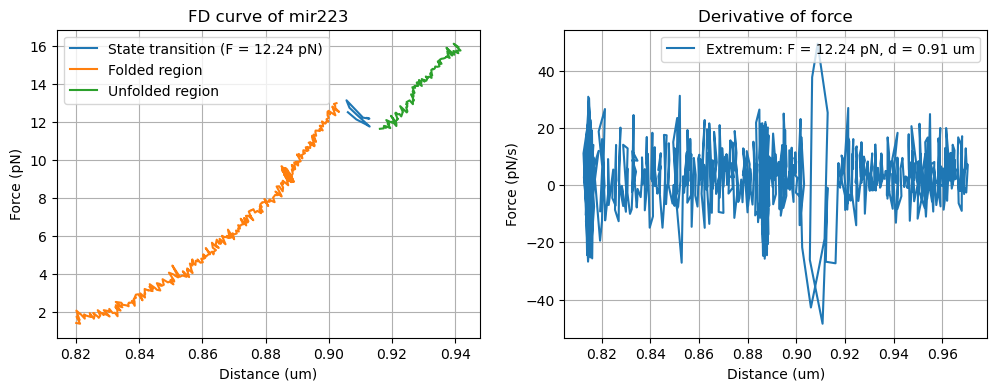

In [475]:
deriv = np.gradient(f_11_down, time_11)
time_11 = time_downsampled[bs+3500:es//3-180]
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
# plt.plot(d_down[bs_:es_//3], f_down[bs_:es_//3])
ax[0].plot(distance_step, force_step, label='State transition (F = 12.24 pN)')
ax[0].plot(distance_back_folded, force_back_folded,label='Folded region')
ax[0].plot(distance_back_unfolded, force_back_unfolded,label='Unfolded region')
ax[0].set_ylabel('Force (pN)')
ax[0].set_xlabel('Distance (um)')
ax[0].set_title('FD curve of mir223')

ax[1].plot(d_11_down, deriv, label = 'Extremum: F = 12.24 pN, d = 0.91 um')
ax[1].set_ylabel('Force (pN/s)')
ax[1].set_xlabel('Distance (um)')
ax[1].set_title('Derivative of force')


def implicit(l):
    min_idx, min_val = min(enumerate(l), key=operator.itemgetter(1))
    return min_idx, min_val
ind_derf, val_derf = implicit(deriv)

for i in range(2):
    ax[i].legend()
    ax[i].grid()


print(f_11_down[ind_derf], d_11_down[ind_derf])

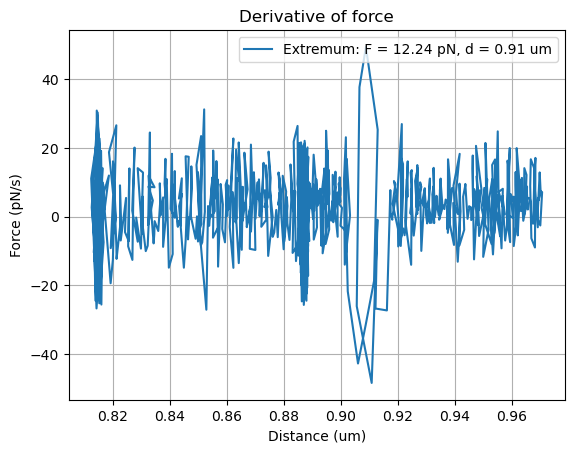

In [478]:
plt.plot(d_11_down, deriv, label = 'Extremum: F = 12.24 pN, d = 0.91 um')
plt.ylabel('Force (pN/s)')
plt.xlabel('Distance (um)')
plt.title('Derivative of force')
plt.legend()
plt.grid()

In [ ]:
dis_str, for_str = cutout_first_stretch([dis_rna, for_rna])
dis_rel, for_rel = cutout_first_relax([dis_rna, for_rna])

d_str, f_str = zip(*sorted(zip(dis_str, for_str)))
cs_str = CubicSpline(d_str, f_str)

d_rel, f_rel = zip(*sorted(zip(dis_rel, for_rel)))
cs_rel = CubicSpline(d_rel, f_rel)

# Scan

In [116]:
file_sc6 = lk.File(file_list[17])
file_sc5 = lk.File(file_list[6])
file_sc4 = lk.File(file_list[5])
file_sc3 = lk.File(file_list[4])
file_sc2 = lk.File(file_list[3])
file_sc1 = lk.File(file_list[0])

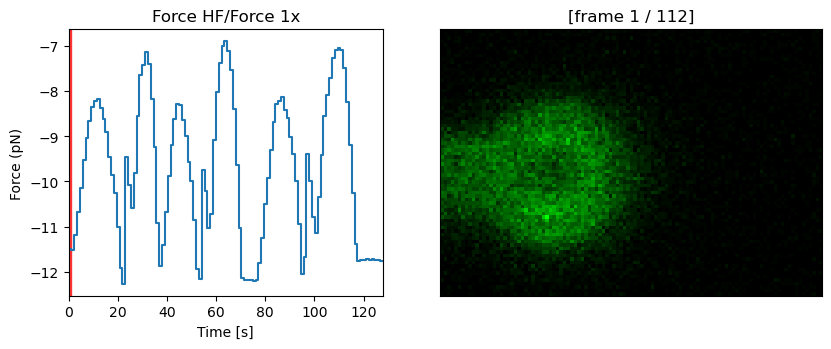

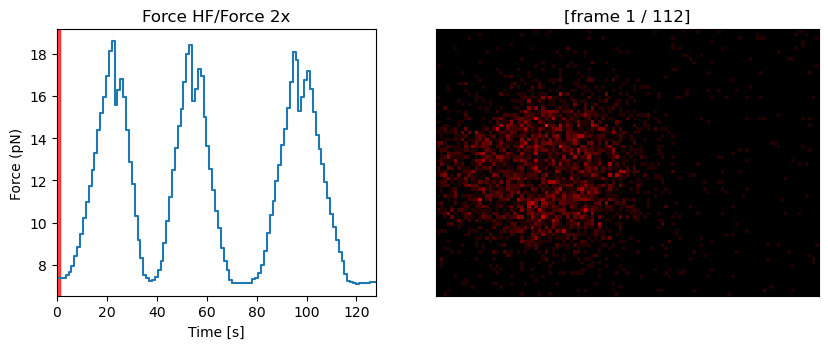

In [110]:
scan = file_sc6.scans["6"]
scan.plot_correlated(file_sc6.force1x, channel="green")
scan.plot_correlated(file_sc6.force2x, channel="red")
                     

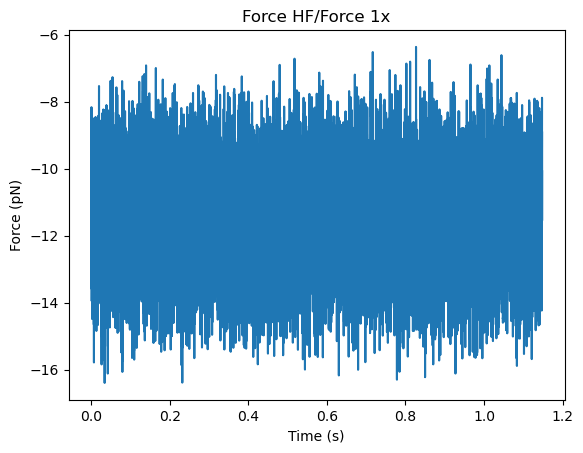

In [76]:
# scan.get_image('rgb')
start, stop = scan.frame_timestamp_ranges()[0]

# Plot the force data corresponding to the first scan.
file_sc6.force1x[start:stop].plot()

In [299]:


# start, stop = scan.frame_timestamp_ranges()[0]

# # Plot the force data corresponding to the first scan.
# file.force1x[start:stop].plot()


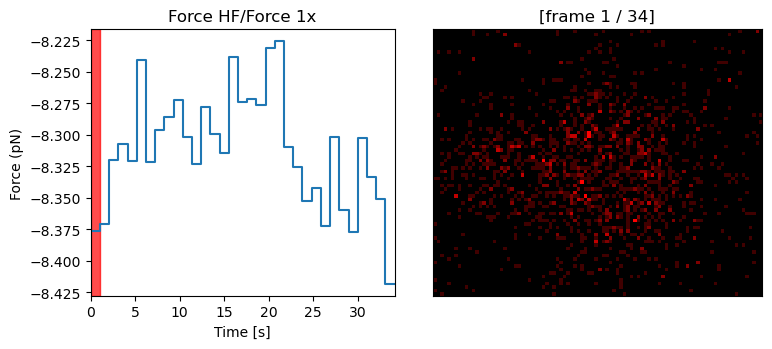

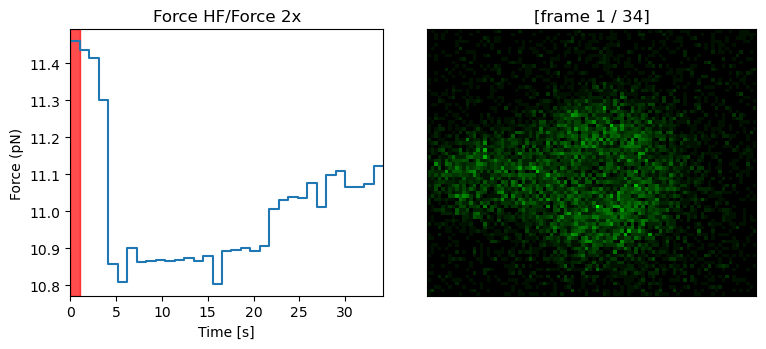

In [113]:
scan = file_sc5.scans["5"]
scan.plot_correlated(file_sc5.force1x, channel="red")
scan.plot_correlated(file_sc5.force2x, channel="green")

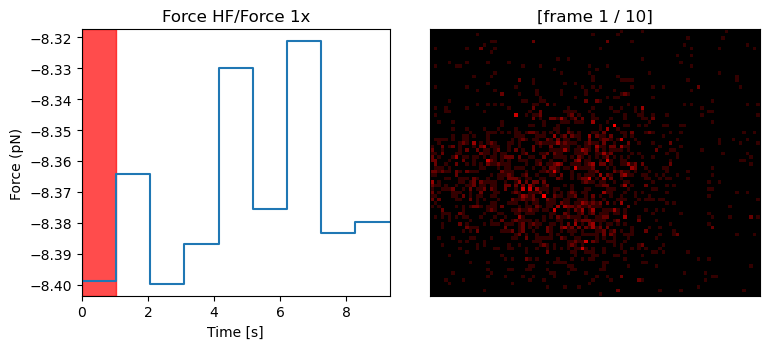

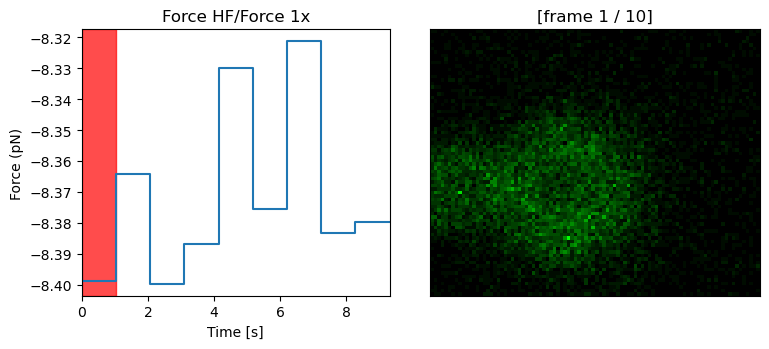

In [115]:
scan4 =file_sc4.scans["4"]
scan4.plot_correlated(file_sc4.force1x, channel="red")
scan4 =file_sc4.scans["4"]
scan4.plot_correlated(file_sc4.force1x, channel="green")

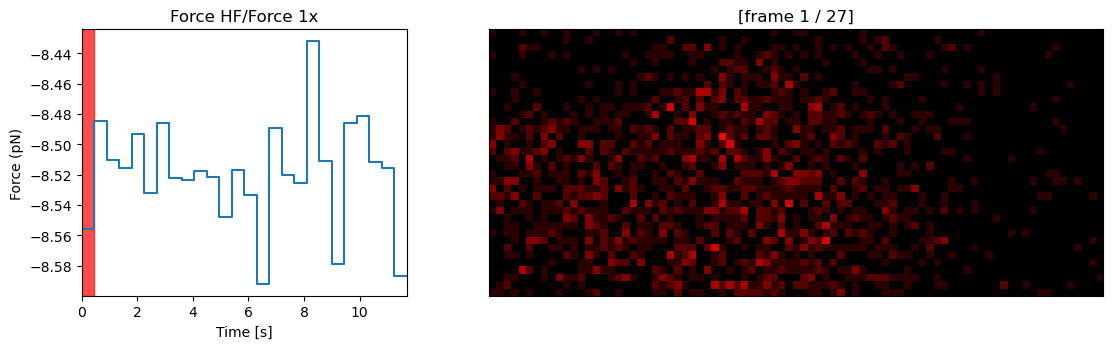

In [120]:
scan3 =file_sc3.scans["3"]
scan3.plot_correlated(file_sc3.force1x, channel="red")

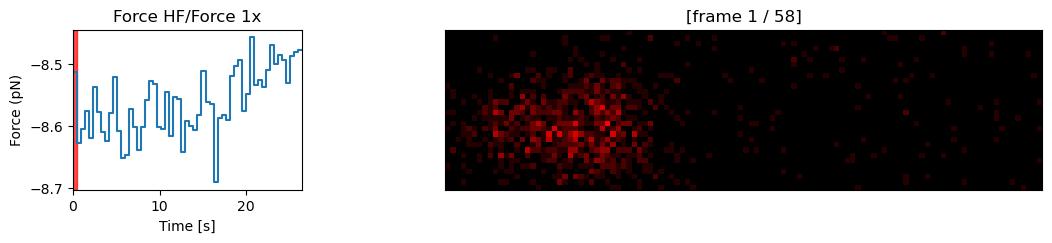

In [121]:
scan2 =file_sc2.scans["2"]
scan2.plot_correlated(file_sc2.force1x, channel="red")

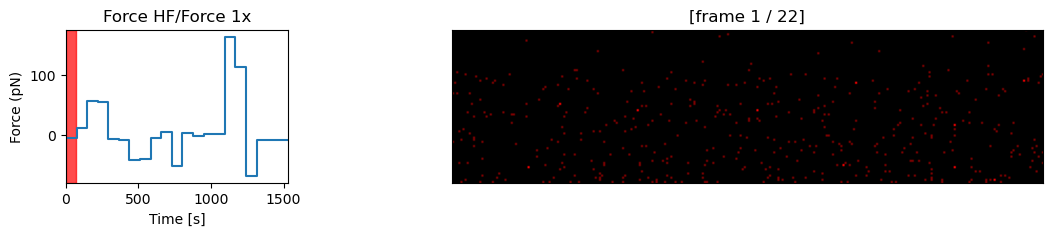

In [122]:
scan1 =file_sc1.scans["1"]
scan1.plot_correlated(file_sc1.force1x, channel="red")